# Mean field Floquet dynamics
Consider the Hamiltonian of the type
\begin{equation}
\hat{H}(t) = \hat{H}_0 + \left(h \cos{(\omega t)} + h_0\right)\; \hat{H}_1,
\end{equation}

where

\begin{eqnarray}
\hat{H}_0 &=& -\frac{1}{2 KacN}\sum_{ij}\hat{\sigma}^z_i\hat{\sigma}^z_j,\\
\hat{H}_1 &=& \sum_i\hat{\sigma}^x_i.
\end{eqnarray}

Here, we have $N$ spin-$1/2$ particles in a $1-$dimensional lattice, and $i,j$ are site indices. We will now attempt a numerical evaluation of
the Floquet eigenspectrum of this system.

First, define permutation operator $P_{ij} = \displaystyle\frac{1}{2}\left(1+ \vec{\sigma}_i\cdot\vec{\sigma}_j\right)$,
and note that $[P_{ij}, H]=0$. Thus, we can reduce the problem size from the full $2^N\times 2^N$ Hilbert space
to the subspace spanned by the degenerate eigenvectors of $P_{ij}$ corresponding to a single eigenvalue, say $1$.
This is isomorphic to the subspace spanned by degenerate eigenstates of the operator $S^2=|\vec{S}|^2$ with eigenvalue
$\displaystyle\frac{N}{2}\left(\frac{N}{2}+1\right)$, where

\begin{equation}
\vec{S}=S^x\hat{x}+S^y\hat{y}+S^z\hat{z}\equiv \sum_i \vec{\sigma}_i.
\end{equation}

Note that, since $[S^2, S^z]=0$, these are also eigenstates of $S^z$ in this so-called
TSS subspace. The corresponding eigenvalues are $Ns_n$, where $s_n=-\frac{1}{2}+\frac{n}{N}$ and the index
$n= 0 (1) N$ has $N+1$ values. Thus

\begin{equation}
S^z |s_n\rangle = Ns_n|s_n\rangle,
\end{equation}

and the matrix elements $(S^z)_{ij} = Ns_s\delta_{ij}$. Furthermore, defining ladder operators

\begin{equation}
S_\pm \equiv S^x \pm i S^y,
\end{equation}

and using the result

\begin{equation}
S_\pm |s_n\rangle = \sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n\pm 1}\right)}\;\;|s_{n\pm 1}\rangle,
\end{equation}

we can obtain the matrix elements $S^x = S_+ + S_-$ to be

\begin{multline}
(S^x)_{nm} = \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n + 1}\right)}\;\;\delta_{n+1, m}  \\
                        +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n- 1}\right)}\;\;\delta_{n-1,m}\bigg]
\end{multline}

Note that, since the Hamiltonian can be readily written as
$H(t) = -\displaystyle\frac{1}{2N}(S^z)^2 - h_0\cos{(\omega t )}S^x$, the matrix elements of
\begin{eqnarray}
\left(H_0\right)_{ij} &=& -\frac{N}{2} s^2_i \delta_{ij},\nonumber\\
\left(H_1\right)_{ij} &=& \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i + 1}\right)}\;\;\delta_{i+1, j}  \\
    & &                     +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i- 1}\right)}\;\;\delta_{i-1,j}\bigg]
\end{eqnarray}

Note that, in the continuum limit, $N\rightarrow\infty$, we can ignore the difference between adjacent values
of $s_i$. Thus, the Hamiltonian per particle becomes $h(t)\equiv \displaystyle\frac{1}{N}H(t) = h + h_0\cos{(\omega t)}h_1$, where

\begin{eqnarray}
\left(h\right)_{ij} &\approx& -\frac{1}{2} s^2_i \delta_{ij},\nonumber\\
h_0 &\rightarrow& -\frac{1}{2}s^2\\
\left(h_1\right)_{ij} &\approx& \frac{1}{2}\sqrt{\frac{1}{4} - s^2_i}\left[\delta_{i+1, j}  + \delta_{i-1,j}\right]\\
h_1 &\rightarrow& \sqrt{\frac{1}{4} - s^2_i}\;\;\cos{p},
\end{eqnarray}
where we have expanded the matrix elements in a basis of $e^{ipx}$. In this limit, we obtain the Lipkin Model (Insert from previous notebook)
.


References:

[1] Check T. Mori's paper equation (12)

## Scatter plot

running for N =  50 with 4 processors
time taken 34.37565153837204 minute


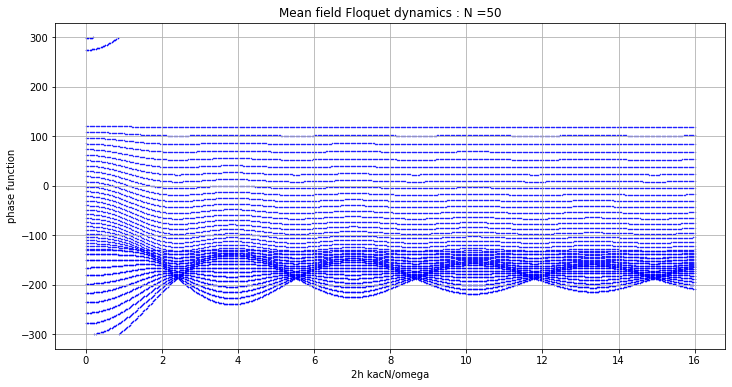

In [4]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time
start = time.time()

# Bessel's root of first order
# 2.40482555769577	5.52007811028631	8.65372791291101	11.7915344390142	14.9309177084877

N = 50
kacN = N
h0 = 0.1
omega = 600
w = omega
tsteps = 500

hsteps = 500
h1 = 1/(2. * kacN) * omega * 0.0
h2 = 1/(2. * kacN) * omega * 16
hs = np.linspace(h1, h2, hsteps)
hpp = (np.ones((N+1,len(hs))) * hs).T

psi = np.eye(N+1) + 1j * np.zeros((N+1,N+1))
H1 = np.zeros((N+1,N+1))

filename1 = 'mfd_fl_h_0-15p5_varies'+str(N)+'real.jpeg'

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
        
def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 2 * np.pi/w                                    
    t = np.linspace(0,2 * np.pi/w,tsteps)                   
    floqEvolution_mat = np.zeros((N+1,N+1)) + 1j * np.zeros((N+1,N+1))
    
    for m in np.arange(N+1):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]        
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j * np.log(evals + 1j * 0) * w/(2 * np.pi)
    return phasefunc.real

if __name__ == '__main__':
    nprocs = 4
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       
   
    spin = 0.5 * np.arange(N+1)[-1]
    s = np.arange(-spin,spin+1) 
    H0 = np.diagflat(0.5 * s **2/kacN)  
    for i in range(N+1):
        for j in range(N+1):
            H1[i][j] = 0.5 * (np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                              + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1))
    
    data = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])    
    print('time taken',(time.time()-start)/60,'minute')
       
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (12,6))
    for xx in np.arange(len(hs)):
        plt.scatter(2 * hpp[xx] * kacN /w, data[xx].real,\
                    color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("2h kacN/omega")
    plt.ylabel("phase function")
    plt.grid()
    #plt.savefig(filename1,dpi=500)
    plt.show()

## Another algorithm for obtaning datat for Floquet spin dynamics for finite size system.


The main advantage of this code is if we try to plot phasefunction apart from scatter plot, then it comes very handy. Check the comment on each of the codes below.

running for N =  40 with 4 processors


/home/mahi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


time taken 0.925593892733256 minute


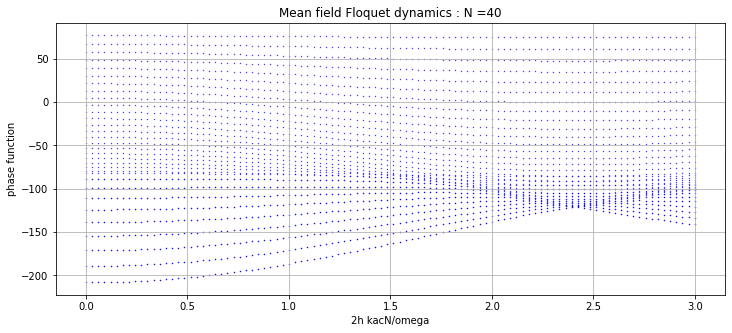

In [27]:
#   Here I have used scatter plot again, but the datafile created here is used 
#   for normal plotting in codes bellow.

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time
start = time.time()

# Bessel's root of first order
# 2.40482555769577	5.52007811028631	8.65372791291101	11.7915344390142	14.9309177084877

N = 40
kacN = N
h0 = 0.1
omega = 600
w = omega
tsteps = 500

hsteps = 100
h1 = 1/(2. * kacN) * omega * 0.0
h2 = 1/(2. * kacN) * omega * 3.
hs = np.linspace(h1, h2, hsteps)
hpp = (np.ones((N+1,len(hs))) * hs).T
#hpp = np.asarray(hpp)
psi = np.eye(N+1) + 1j * np.zeros((N+1,N+1))
H1 = np.zeros((N+1,N+1))

filename1 = 'mfd_fl_h_0-15p5_varies'+str(N)+'real.jpeg'

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
        
def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 2 * np.pi/w                                    
    t = np.linspace(0,2 * np.pi/w,tsteps)                   
    floqEvolution_mat = np.zeros((N+1,N+1)) + 1j * np.zeros((N+1,N+1))
    
    for m in np.arange(N+1):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]        
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j * np.log(evals + 1j * 0) * w/(2 * np.pi)
    return [h,phasefunc.real,evecs]

if __name__ == '__main__':
    nprocs = 4
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       
   
    spin = 0.5 * np.arange(N+1)[-1]
    s = np.arange(-spin,spin+1) 
    H0 = np.diagflat(0.5 * s **2/kacN)  
    for i in range(N+1):
        for j in range(N+1):
            H1[i][j] = 0.5 * (np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                              + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1))
    
    data1 = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])
    data = np.asarray(data1,dtype=None).reshape((len(hs),3))
    h_f = data[:,[0]]
    phs_f = data[:,[1]]
    evec_f = data[:,[2]]
    print('time taken',(time.time()-start)/60,'minute')
    
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (12,5))
    for xx in np.arange(len(hs)):
        plt.scatter(2 * hpp[xx] * kacN /w, phs_f[xx][0].real,\
                    color = 'blue', marker='.', s = 0.5)
    plt.title(title)    
    plt.xlabel("2h kacN/omega")
    plt.ylabel("phase function")
    plt.grid()
    #plt.savefig(filename1,dpi=500)
    plt.show()

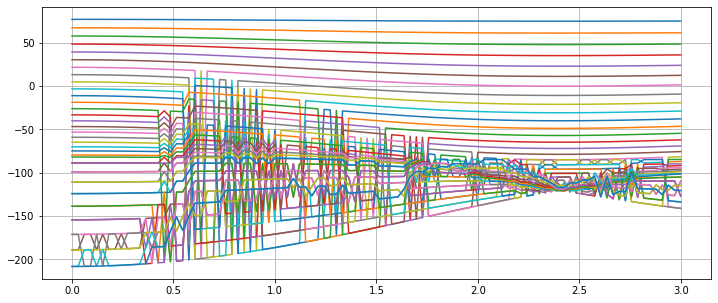

In [28]:
# This looks okay code till now
# Here I have used column wise phase function data

plt.figure(figsize = (12,5))
for j in range(N+1):    
    hh = np.zeros(hsteps)
    ph = np.zeros(hsteps)
    for i in range(hsteps):
        hh[i] = data1[i][0]
        ph[i] = data1[i][1][j]
    plt.plot(2 * hh * kacN/omega ,ph)
#plt.xlim(2.,3.)
#plt.ylim(-230,-100)
plt.grid()
plt.show()

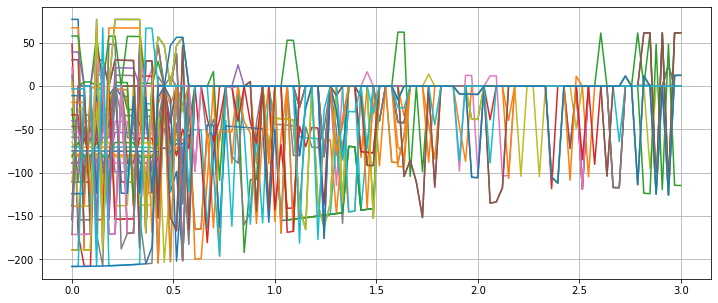

In [30]:
# Here I have tried to go according to unity star product between two states


import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
for j in range(N+1):    
    hh = np.zeros(hsteps)
    ph = np.zeros(hsteps)
    hh[0] = data1[0][0]
    ph[0] = data1[0][1][j]
    prev_state = data1[0][2][j]
    for i in range(1,hsteps):
        hh[i] = data1[i][0]
        for k in range(N+1):
            if (np.round(np.dot(np.conjugate(prev_state).T,data[i][2][k])) == 1.0):  
                ph[i] = data[i][1][k]
                prev_state = data[i][2][k]
                break
    plt.plot(2 * hh * kacN/omega ,ph)
plt.grid()
plt.show()

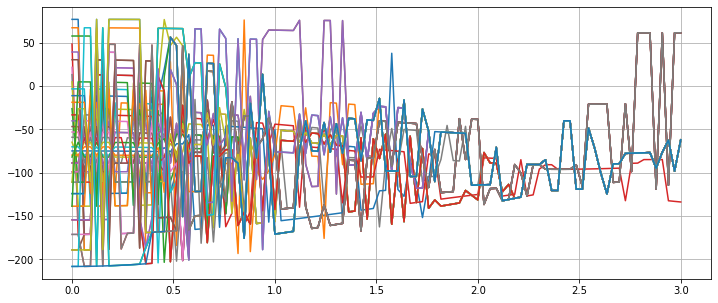

In [31]:
# Here I have tried to go according to  maximum star product between two states


import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))

prob = np.zeros(N+1)
for j in range(N+1):    
    hh = np.zeros(hsteps)
    ph = np.zeros(hsteps)
    hh[0] = data1[0][0]
    ph[0] = data1[0][1][j]
    prev_state = data1[0][2][j]
    for i in range(1,hsteps):
        hh[i] = data1[i][0]
        for k in range(N+1):
            prob[k] = np.dot(np.conjugate(prev_state).T,data[i][2][k]).real
        for mm, pr in enumerate(prob):
            if (pr == np.max(prob)):    
                ph[i] = data[i][1][mm]
                prev_state = data[i][2][mm]
                break
    plt.plot(2 * hh * kacN/omega ,ph)
plt.grid()
plt.show()

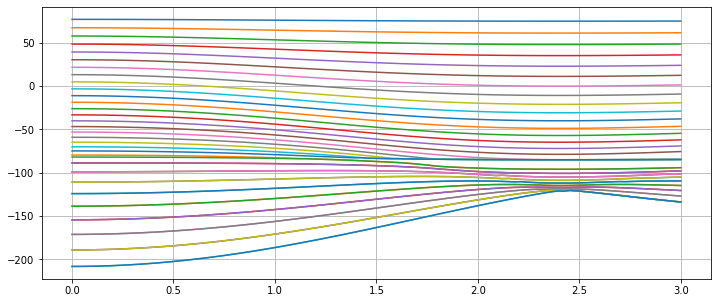

In [32]:
# Here I have tried to use nearest valued phasefunction

import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

prob = np.zeros(N+1)
for j in range(N+1):    
    hh = np.zeros(hsteps)
    ph = np.zeros(hsteps)
    hh[0] = data1[0][0]
    ph[0] = data1[0][1][j]
    prev_ph = data1[0][1][j]
    for i in range(1,hsteps):
        hh[i] = data1[i][0]
        ph[i] = find_nearest(data[i][1],np.array([prev_ph]))
        prev_ph = ph[i]
    plt.plot(2 * hh * kacN/omega ,ph)
plt.grid()
plt.show()

## some datafile handling method

In [27]:
import numpy as np
filename = 'mahi.txt'

a = np.zeros(3);b = np.zeros(3)
for i in np.arange(3):
    a[i] = i
    b[i] = i * i * i
print(a,b)
dataout = np.column_stack((a,b))
np.savetxt(filename,dataout)
print('done !')

[0. 1. 2.] [0. 1. 8.]
done !


In [28]:
dataout = np.row_stack((a,b))
np.savetxt(filename,dataout)
print('done !')

done !


In [36]:
N = 5
spin = 0.5 * np.arange(N+1)[-1]
s = np.arange(-spin,spin+1)
print(s)    

[-2.5 -1.5 -0.5  0.5  1.5  2.5]
